### TELEPATH.IO INTERN ###

#### How did I solve the task? ####

Data Analysis: 

- From first glance I can spot that this is Stock Price prediction (I had experience in trading and stock market).

- Our input are 3 months everyday stock price info 

Feature Engineering:

- I created 2 extra feature: Difference between low and high of everyday, and difference between open and close of everyday. 

- The reason is that, as a trader myself, I understand the common energy (or vibe) among stock traders, for a specific stock matters. For example, one is unlikely to buy or sell, when no one else is buying or selling. The amount of short-term traders also reflected in the difference between low-high.

- I also wrote an extra part to test out my features selection, details below.

Model Building

- I did some research, and I agree with the internet that LSTM should be the best way to solve this problem. 

- "What is LSTM? Do I understand it or did I just copied what's online?". I learned LSTM in my Natural Language Processing (NLP) class, which is a typical and common way for text generation. Makes sense to me to use LSTM here, since texts and stock price are time-series that basically have the same principle.

- My LSTM reference partly from here. https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch/notebook

Testing my model

- I test my model using RMSE. I think RMSE is the suitable measure in this case, since we want to get our numbers as close as possible. 

- I have train - validation - test sets. An Adaptive function that train on train set, test on validation set, to choose the suitable parameters based on the dataset. Then get my final result (in RMSE) from test set. 

#### How do I explain my work? ###

- I have comments above mostly every line of codes I wrote. Hopefully you find it clear, but I am more than happy to answer any confusions. 

### Communication ###

- Other than the help from the internet (the kaggle link I provided above), I did this on my own. 

- I made a lot of modification comparing to the kaggle link, so I hope it is fine. I think researching is part of our jobs anyways. 

### Creative/ Criticial Thinking ###

- So I'm not quite sure how to answer this one properly xD.

- I would say creating the difference between open-close and low-high is creative. But at the same time I just feel that I got lucky, thanks to having experience in tradings. 

- I would say that I created a scalable, adaptive pipeline, for future data self-adjust is creative, but on the otherhand, I believe it is what I needed to do 

- One thing I spot after playing around with the data is that: since our data is limited, those period where stock price are stable produces better predictions comparing to those period with lots of change. 

- Hopefully you can see my creativity while going through my codes. 

### Extra ###

- I know that my work is not perfect, but I hope that it is enough to show you that I have the ability to learn, and the potential to thrive in the future. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import copy
from pylab import plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

In [111]:
#Read file
def read_file(file_name):
  file = pd.read_csv(file_name)
  return file


#Preprocessing data
def preprocess_file(eth):

  #change 'date' to date time format
  eth['date'] = pd.to_datetime(eth["date"])

  #sort by date, from oldest to latest
  eth = eth.sort_values(by="date")

  #add more features
  eth['high_low_dif'] = eth['high'] - eth['low']
  eth['open_close_dif'] = eth['open'] - eth['close']

  #set date as index
  eth = eth.set_index(['date'])

  # Standard scalers on columns
  scale_cols = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume','high_low_dif', 'open_close_dif' ]
  scale_data = eth[scale_cols]

  #Scaling dictionary for inverse transform later
  scaler = {}
  for c in scale_cols:
    scaler[c] = StandardScaler()
    eth[c] = scaler[c].fit_transform(eth[c].values.reshape(-1,1))

  return eth, scaler


#info: numpy arrays
#lookback: int (days for LSTM to look back)
#days_forecast: int (days for LSTM to look ahead, or forecast)
def load_data(info, lookback, days_forecast, valid_set = True):

  #in total days
  n = days_forecast

  #create data, all possible sequences with length lookback, to feed into LSTM
  data = []
  for i in range(len(info) - lookback + 1):
    data.append(info[i:i+lookback])
  data = np.array(data)
  data_size = data.shape[0]

  #if we want validation set
  if valid_set == True:
    #create train + validation set size
    train_val_size = int(np.round(0.84 * data_size))

    #create test set size
    test_size = data_size - train_val_size

    #create train set size
    train_size = int(np.round(0.8 * train_val_size))

    #create validation set size
    val_size = train_val_size - train_size

    #create train-val-test sets
    #each entry of x_train, x_val, x_test is a sequence of look back days - forecast days
    x_train = data[:train_size, :-n, :]
    x_val = data[train_size: train_size + val_size, :-n, :]
    x_test = data[train_val_size:, :-n, :]

    #each entry of y_train, y_val, y_test is a sequence of forecast days
    if data.shape[2] == 1:
      #only 'close' column, index 3
      y_train = data[:train_size, -n:, 0]
      y_val = data[train_size: train_size + val_size, -n:, 0]
      y_test = data[train_val_size:, -n:, 0]
    else:
      #only 'close' column, index 3
      y_train = data[:train_size, -n:, 3]
      y_val = data[train_size: train_size + val_size, -n:, 3]
      y_test = data[train_val_size:, -n:, 3]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    y_val = torch.from_numpy(y_val).type(torch.Tensor)
    x_val = torch.from_numpy(x_val).type(torch.Tensor)

  #if we do not want validation set
  else:
    #create train size
    train_size = int(np.round(0.8 * data_size))

    #create test set size
    test_size = data_size - train_size

    #create train-test sets
    #each entry of x_train, x_test is a sequence of look back days - forecast days
    x_train = data[:train_size, :-n, :]
    x_test = data[train_size:, :-n, :]

    #each entry of y_train, y_test is a sequence of forecast days
    if data.shape[2] == 1:
      y_train = data[:train_size, -n:, 0]
      y_test = data[train_size:, -n:, 0]
    else: 
      #only 'close' column, index 3
      y_train = data[:train_size, -n:, 3]
      y_test = data[train_size:, -n:, 3]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    y_val = None
    x_val = None

  return [x_train, y_train, x_val, y_val, x_test, y_test]
  

#create LSTM
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim, days_forecast):
    super(LSTM, self).__init__()
    self.days_forecast = days_forecast
    self.output_dim = output_dim
    self.hidden = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim*days_forecast)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])
    out = torch.reshape(out, (-1, self.days_forecast, self.output_dim))
    return out


def create_LSTM(input_dim, hidden_dim, num_layers, output_dim, days_forecast):
  model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers, days_forecast = days_forecast)
  return model


#training function
def train(model, num_epochs, x_train, y_train, graphing = False):
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  hist = np.zeros(num_epochs)
  for e in range(num_epochs):
    y_train_pred = model(x_train)
  
    #comparing with 'close' column of y_train, because we are trying to predict 'close'
    loss = loss_fn(y_train_pred.squeeze(), y_train)
    hist[e] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
  
  # graph training loss
  if graphing == True:
    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()

  return model

#evaluation function
def evaluation(model, x_train, y_train, x_val, y_val, scaler):
  #make predictions
  y_train_pred = model(x_train).detach().numpy()
  y_val_pred = model(x_val).detach().numpy()
  
  #reduce dimension
  y_val_pred = y_val_pred.squeeze()
  y_train_pred = y_train_pred.squeeze()

  # #only the 'close' feature
  # y_train = y_train[:, :, 3]
  # y_val = y_val[:, :, 3]

  #inverse transform
  y_train_pred = scaler['close'].inverse_transform(y_train_pred)
  y_train = scaler['close'].inverse_transform(y_train)
  y_val_pred = scaler['close'].inverse_transform(y_val_pred)
  y_val = scaler['close'].inverse_transform(y_val)

  #RMSE
  train_error = sqrt(mean_squared_error(y_train, y_train_pred))
  val_error = sqrt(mean_squared_error(y_val, y_val_pred))
  return train_error, val_error


In [102]:
###### ADAPTIVE PIPELINE #######
file_name = "/content/gdrive/My Drive/Telepath/stockprice/eth.csv"
file = read_file(file_name)
file, scaler = preprocess_file(file)

def adaptive(file):
  #Initialize
  days_forecast = 6
  days_look_back = [10, 15, 20, 30]
  num_epochs = [100, 150, 200, 300, 600]
  hidden_dim = 32
  num_layers = 2
  output_dim = 1

  #Find the best parameters to our dataset
  min_error = 999999
  optimalModel = None
  optimalLookback = None
  optimalEpochs = None
  for d in days_look_back:
    x_train, y_train, x_val, y_val, x_test, y_test = load_data(file, d, days_forecast)
    input_dim = x_train.shape[2]

    for e in num_epochs:

      model = create_LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers, days_forecast = days_forecast)

      model = train(model, e, x_train, y_train)

      error_train, error_val = evaluation(model, x_train, y_train, x_val, y_val, scaler)

      if error_val < min_error:
        min_error = error_val
        optimalModel = copy.deepcopy(model)
        optimalLookback = d
        optimalEpochs = e

  print('Optimal Epochs:', optimalEpochs)
  print('Optimal Days to Lookback', optimalLookback)

  #Use the best parameters to train and predict
  x_train, y_train, x_val, y_val, x_test, y_test = load_data(file, optimalLookback, days_forecast, valid_set = False)
  input_dim = x_train.shape[2]
  model = create_LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers, days_forecast = days_forecast)
  model = train(model, optimalEpochs, x_train, y_train)
  error_train, error_test = evaluation(model, x_train, y_train, x_test, y_test, scaler)
  print('RMSE on Test Data:', error_test)
  return model, error_test, optimalLookBack

In [103]:
##### RESULTS GET BETTER WITH MORE DATA? ######

sample_size = [55, 70, 85, 100]
error = []
for s in sample_size:
  data_shorten = file.iloc[:s, :]
  print('Current Number of sample:', data_shorten.shape)
  model, error_s, optimalLookBack = adaptive(data_shorten)
  error.append(error_s)


Current Number of sample: (55, 10)
Optimal Epochs: 200
Optimal Days to Lookback 20
RMSE on Test Data: 192.20159215425866
Current Number of sample: (70, 10)
Optimal Epochs: 100
Optimal Days to Lookback 10
RMSE on Test Data: 380.2253896567514
Current Number of sample: (85, 10)
Optimal Epochs: 300
Optimal Days to Lookback 30
RMSE on Test Data: 330.36040874425413
Current Number of sample: (100, 10)
Optimal Epochs: 100
Optimal Days to Lookback 15
RMSE on Test Data: 387.6862898528516


Text(0.5, 0, 'Sample Size')

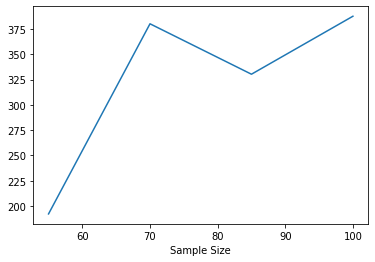

In [104]:
plt.plot(sample_size, error)
plt.xlabel('Sample Size')

### It seems to me here is that, period with less sudden changes in stock price (before August),
### the model does better. It is not because we have more or less data. 
### Apparently there is not much different between 50-100 samples. Maybe 100-1000, we can see the difference

In [97]:
#### Testing Features ####
error_f = []
### Input only 'close' column ###
only_close = np.expand_dims(file.iloc[:,3], axis = 1)
model, error_fc, optimalLookBack = adaptive(only_close)
error_f.append(error_fc)

### Input without open_close_dif and low_high_dif ###
without_dif = file.iloc[:, :8]
model, error_fd, optimalLookBack = adaptive(without_dif)
error_f.append(error_fd)

### Input with all features ###
model, error_fa, optimalLookBack = adaptive(file)
error_f.append(error_fa)


Optimal Epochs: 150
Optimal Days to Lookback 30
RMSE on Test Data: 445.3308151096796
Optimal Epochs: 100
Optimal Days to Lookback 20
RMSE on Test Data: 502.2518840533326
Optimal Epochs: 150
Optimal Days to Lookback 20
RMSE on Test Data: 397.50405541961914


Text(0.5, 1.0, 'RMSE Comparision')

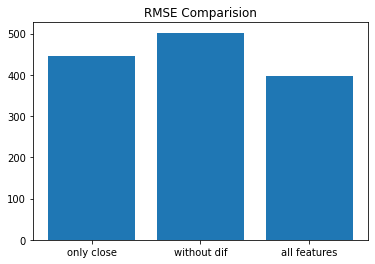

In [100]:
plt.bar(['only close', 'without dif', 'all features'],error_f)
plt.title('RMSE Comparision')
# and using all features, including low-high dif and close-open dif increase our accuracy

In [112]:
### Pre-set Parameters ###

##### A function that we can set the parameters #####
def preset(file, days_look_back, num_epochs, valid_set = False):
  days_forecast = 6
  hidden_dim = 32
  num_layers = 2
  output_dim = 1

  # create traintestval set
  x_train, y_train, x_val, y_val, x_test, y_test = load_data(file, days_look_back, days_forecast, valid_set = valid_set)
  
  input_dim = x_train.shape[2]
  model = create_LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers, days_forecast = days_forecast)
  model = train(model, num_epochs, x_train, y_train, graphing = True)

  error_train, error_test = evaluation(model, x_train, y_train, x_test, y_test, scaler)
  return model, error_train, error_test



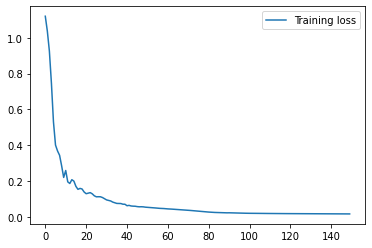

Train set error 75.68793105059899
Test set error 390.1272061466462
Predict day 94th to day 99th
RMSE: 83.98178807770086


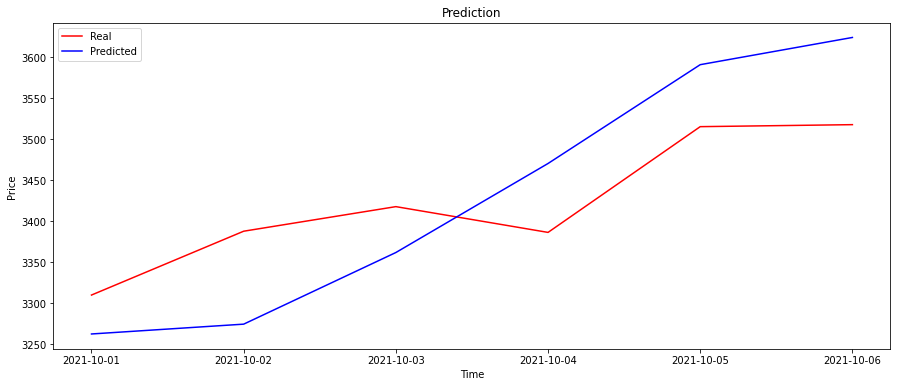

In [154]:
### Assuming our original data is from day 0 to day 92nd. We get new input day 93rd. 
### Let's predict day 94th to 99th (6 days), and compare with real value
data_to_93 = file.iloc[:93, :]
days_look_back = 17
num_epochs = 150
model, error_train, error_s = preset(data_to_93, days_look_back, num_epochs )

print('Train set error', error_train)
print('Test set error', error_s)

#create sequence to look back, until the latest day
newData = torch.from_numpy(np.array([file.iloc[94-days_look_back:94, :]])) 

#get prediction and inverse transform to measure RMSE
prediction = model(newData.type(torch.Tensor)).detach().numpy().squeeze()
prediction = scaler['close'].inverse_transform(prediction.reshape(6,1))

#real value
real = scaler['close'].inverse_transform(np.array(file.iloc[94:, 3]).reshape(6,1))

#RMSE
error = sqrt(mean_squared_error(real, prediction))
print('Predict day 94th to day 99th')
print('RMSE:', error)

#plot the graph
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(file[94:].index, real, color = 'red', label = 'Real')
axes.plot(file[94:].index, prediction, color = 'blue', label = 'Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()